In [1]:
import numpy as np
import pandas as pd
import sys, os, subprocess  
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display

In [ ]:
plt.style.use('dark_background')
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

new_datasets_path:str = ""
image_path:str = ""
root: str = ""
dataset_path : str = ""
Save_path = ""
Model_Path = ""

# **Illustration Code**

In [3]:
def Draw_hysteresis(subset: pd.DataFrame, max_plots: int = 10):
    # Sanity‐check columns
    for col in ('breath_id','u_in','u_out','pressure','time_step'):
        if col not in subset.columns:
            raise KeyError(f"Column '{col}' missing from subset")

    # Iterate over at most `max_plots` unique breath_ids
    for i, bid in enumerate(subset['breath_id'].unique()):
        if i >= max_plots:
            break

        df_slice = (subset[subset['breath_id'] == bid]
                    .sort_values(by="time_step"))
        dynamics = df_slice[['u_in','u_out','pressure','time_step']]\
                       .to_dict(orient='list')
        plot_hysteresis(dynamics)

        
   



def plot_hysteresis(hysteresis_dynamics):
    sns.set_theme(style="white", rc={
        "axes.facecolor": "#1c1c1c",
        "grid.color": "#444444",  # Slightly lighter than background
        "figure.facecolor": "#1c1c1c"
    })

    TV_i = np.array(hysteresis_dynamics['u_in'])
    TV_e = np.array(hysteresis_dynamics['u_out'])
    pressure = np.array(hysteresis_dynamics['pressure'])
    TV_total = TV_i + TV_e

    plt.ion()  
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_title('Hysteresis Loop: TV-total/Pressure - 32.0 Hz', fontsize=16, color="white", pad=15)
    ax.set_xlabel('TV-total (TV-i + TV-e)', fontsize=14, color="white")
    ax.set_ylabel('Pressure', fontsize=14, color="white")
    
    plt.xticks(color="white")
    plt.yticks(color="white")

    # Add grid with custom color and style
    ax.grid(True, color="#444444", linestyle='--', linewidth=0.5)

    # Initialize the line object
    line, = ax.plot([], [], marker='o', linestyle='-', color='cyan', label='Hysteresis (TV-total / Pressure)')

    legend = ax.legend(facecolor="black", edgecolor="white", fontsize=12, loc='upper right')  
    for text in legend.get_texts():
        text.set_color("white")

    # Loop through the data to create the plot
    for i in range(len(TV_total)):
        line.set_data(TV_total[:i+1], pressure[:i+1])
        ax.relim()          
        ax.autoscale_view() 
        fig.canvas.draw()   
        fig.canvas.flush_events() 

    plt.ioff()  
    plt.show()




def HeatMap(DataSet: pd.DataFrame):
    sns.heatmap(DataSet.corr(), annot=True)
    plt.show()

def Draw_Feature(DataSet: pd.DataFrame, id: int, target: str):
    plt.figure(figsize=(14, 6))
    Random_id = DataSet[DataSet['breath_id'] == id].copy()
    Random_id = Random_id.sort_values(by="time_step")

    sns.lineplot(x=Random_id['time_step'], y=Random_id[target], label=target)
    sns.lineplot(x=Random_id['time_step'], y=Random_id['pressure'], label='Pressure')
    plt.legend()
    plt.show() 


# **Label Assessments**

In [4]:
# Processed Dataset
os.chdir(new_datasets_path)
transfored_set = pd.DataFrame()
transfored_set = pd.read_csv("Final_Dataset.csv")
transfored_set.drop(transfored_set.columns[[0]],axis=1,  inplace=True) 
transfored_set.rename(columns={'breath_ids':'breath_id'}, inplace=True)
transfored_set.head()

,u_in_std,pressure_std,Polynomial_Area,Hull_Area,ft_TV_1,ft_TV_2,ft_TV_3,ft_TV_4,ft_TV_5,ft_P_1,...,ft_P_4,ft_P_5,Perimeter,Width,Height,Centroid_X,Centroid_Y,Curvature,Cluster,breath_id
0,0.000000,0.000000,282.157479,350.167422,484.607933,183.391093,68.468914,56.159057,51.404353,1082.775828,...,67.671789,116.198749,122.759376,18.353980,22.777895,6.057599,13.534698,11.190253,0,3
1,0.000000,0.000000,28.139413,74.872299,300.129994,60.284442,68.542576,55.210521,40.204153,642.684398,...,37.449278,53.714602,65.228595,8.975885,9.982905,3.751625,8.033555,13.949885,1,7
2,-1.221946,-0.984998,218.777887,272.316931,477.517065,167.435953,75.304841,40.280884,57.576735,1046.921734,...,41.169516,109.287272,111.338845,16.383765,21.793665,5.968963,13.086522,4.491883,0,10
3,0.000000,0.000000,31.145178,15.969105,274.582413,79.187200,56.413160,32.779015,28.114756,548.198314,...,14.786057,1.780922,38.983140,5.990302,3.936920,3.432280,6.852479,254.399679,1,20
4,0.000000,0.000000,237.400212,301.631449,434.662665,101.799568,154.094102,80.326598,43.306234,972.401460,...,135.713795,30.636842,105.555013,13.125972,27.417837,5.433283,12.155018,11.018074,0,40


In [5]:
# Default interpolated dataset
DataSet = pd.DataFrame()
DataSet = pd.read_csv("TS_Data.csv")
DataSet.drop(DataSet.columns[[0]], axis=1, inplace=True)

In [6]:
def GetClusterSample(DataSet: pd.DataFrame, Extracted_df: pd.DataFrame,
                     cluster_id: int, n: int = 10, random: bool = True,
                     random_state: int = 0) -> pd.DataFrame:

    cluster_mask = Extracted_df["Cluster"].values == cluster_id
    breath_ids = Extracted_df.loc[cluster_mask, "breath_id"].values
    
    # 2. Handle empty case early
    if len(breath_ids) == 0:
        return pd.DataFrame(columns=keep)
    
    # 3. Optimized sampling using numpy
    n = min(n, len(breath_ids))
    if random:
        rng = np.random.default_rng(random_state)
        selected_ids = rng.choice(breath_ids, size=n, replace=False)
    else:
        selected_ids = breath_ids[:n]
    
    # 4. Use efficient merging with index
    keep = ['breath_id','time_step','pressure', 'u_in', 'u_out']
    return DataSet.merge(
        pd.DataFrame({'breath_id': np.unique(selected_ids)}),
        on='breath_id',
        how='inner'
    )[keep]

In [7]:
transfored_set.shape[0]

11376

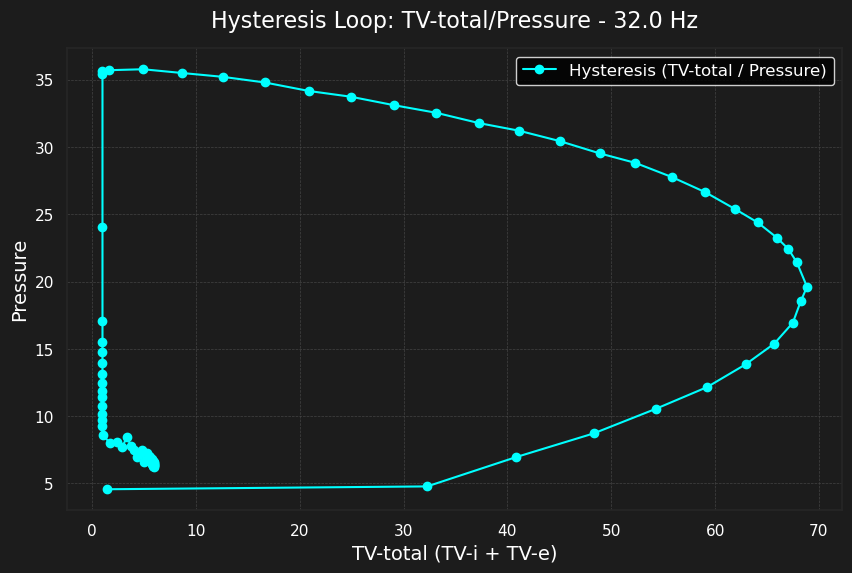

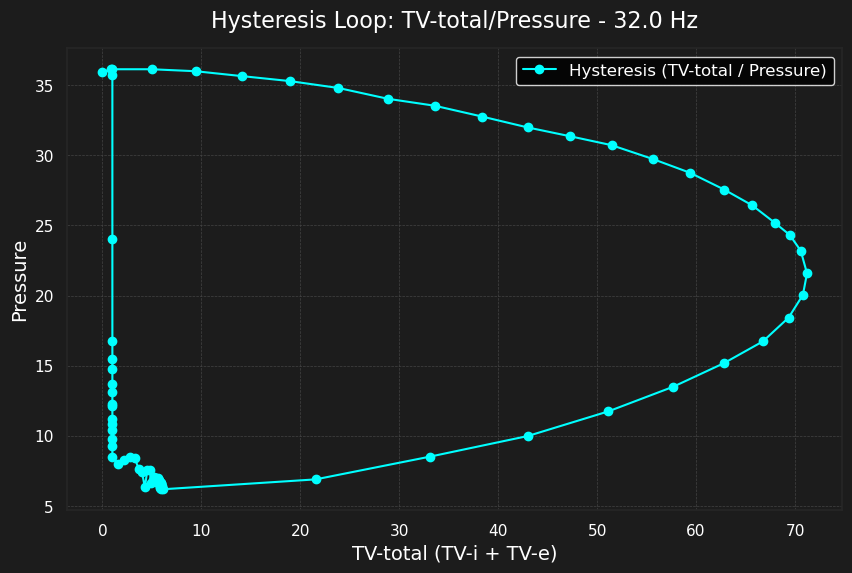

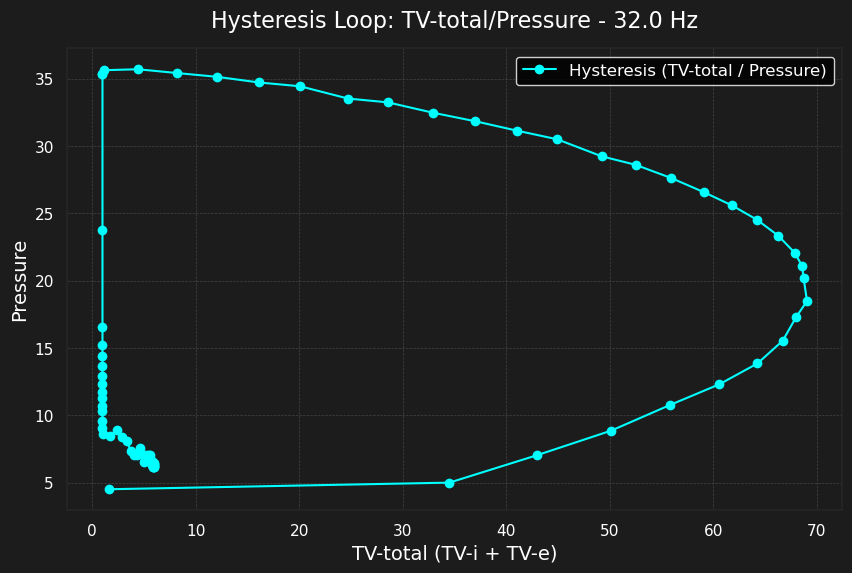

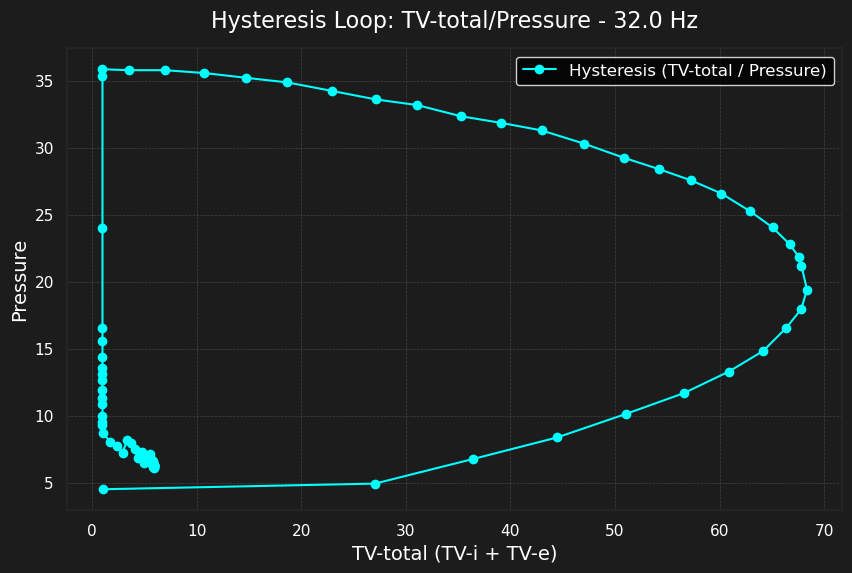

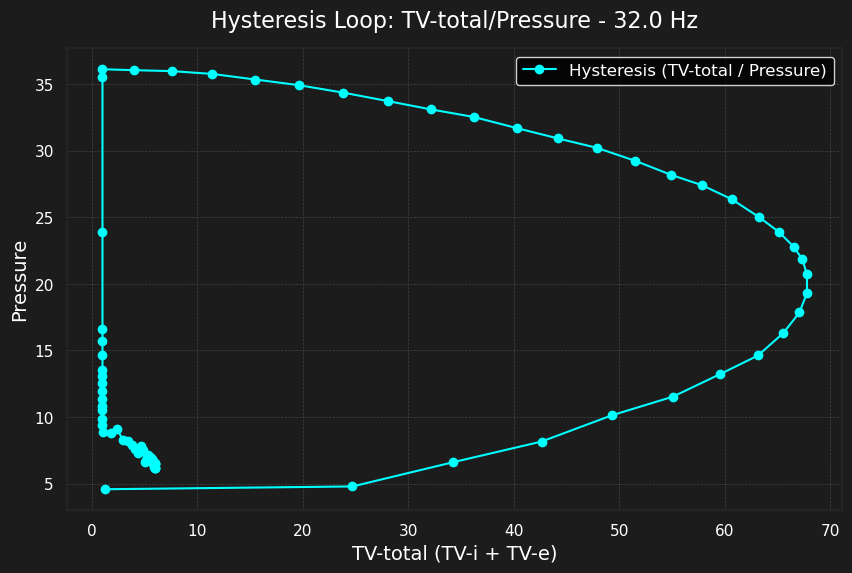

In [23]:
subset = GetClusterSample(DataSet, transfored_set, 7,10,True)
Draw_hysteresis(subset,5)